In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Flatten, Lambda, BatchNormalization, Conv1D
from tensorflow.keras.layers import Reshape, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

import random as rn
import numpy as np
import easydict
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

import sounddevice as sd

import pandas as pd
import tensorflow as tf
import glob

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

import IPython.display as ipd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import style
import seaborn as sns

%matplotlib inline
sns.set(style='whitegrid', color_codes=True)

In [2]:
seed = 100
np.random.seed(seed)
rn.seed(seed)
tf.set_random_seed(seed)

In [3]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [4]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [5]:
labels = pd.read_csv('train_labels.csv')
sample_solution = pd.read_csv('sample_submission.csv')
train = np.load('train_data.npy')
test = np.load('test_data.npy')

In [6]:
print(train.shape)
print(test.shape)

(3999, 44100)
(3997, 44100)


In [7]:
#resize
train_labels = labels.drop('Id', 1)
Y = to_categorical(train_labels,2)

# x_train, x_test, y_train, y_test = train_test_split(
#     train, Y, test_size=0.2, random_state=seed)

x_train = train.reshape(-1,210,210,1)
x_test = test.reshape(-1,210,210,1)

print("TRAIN SHAPE")
print(x_train.shape)
print("TEST SHAPE")
print(x_test.shape)


image_size = x_train.shape[1]

TRAIN SHAPE
(3999, 210, 210, 1)
TEST SHAPE
(3997, 210, 210, 1)


In [8]:
# network parameters
input_shape = (210,210,1)
batch_size = 61
kernel_size = 3
filters = 128
latent_dim = 2
epochs = 10

In [9]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

W0923 17:27:56.582086 140540617684800 deprecation.py:506] From /home/trent/anaconda2/envs/machine-learning/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 210, 210, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 105, 105, 256 2560        encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 53, 53, 512)  1180160     conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1438208)      0           conv2d_1[0][0]                   
____________________________________________________________________________________________

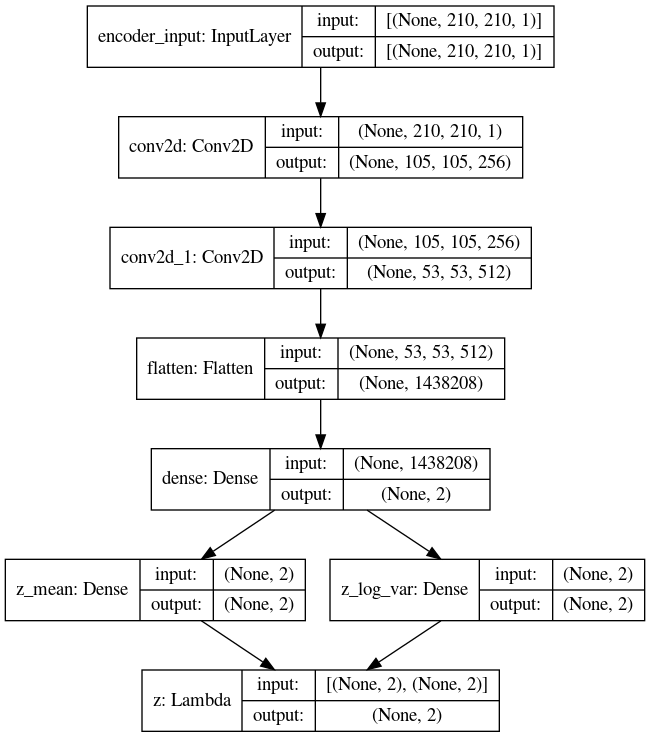

In [10]:
# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(2, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)


In [11]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
print(latent_inputs.shape)
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

(?, 2)


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1438208)           4314624   
_________________________________________________________________
reshape (Reshape)            (None, 53, 53, 512)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 106, 106, 512)     2359808   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 212, 212, 256)     1179904   
_________________________________________________________________
decoder_output (Conv2DTransp (None, 212, 212, 1)       2305      
Total params: 7,856,641
Trainable params: 7,856,641
Non-trainable params: 0
_________________________________________________

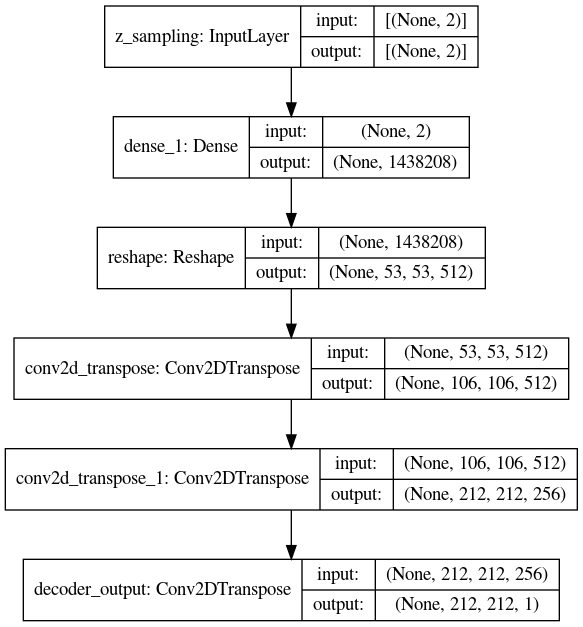

In [12]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

In [13]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[1])
vae = Model(inputs, outputs, name='vae')

In [ ]:
args = easydict.EasyDict({
    'mse': False,
    'weights': False
})
models = (encoder, decoder)
# data = (x_test, y_test)


# VAE loss = mse_loss or xent_loss + kl_loss
if args.mse:
    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
else:
    reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                              K.flatten(outputs))

reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()
plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

if args.weights:
    vae.load_weights('vae_cnn_gunshot.h5')
else:
    # train the autoencoder
    vae.fit(x_train, x_train,
            epochs=epochs,
            batch_size=batch_size,
            )
    vae.save_weights('vae_cnn_gunshot.h5')
#     plot_results(models, data, batch_size=batch_size, model_name="vae_cnn")

In [ ]:
print(x_test.shape)

In [ ]:
print(Y_train.shape)